# Домашнее задание №4 по машинному обучению
### Временные ряды

### Импорт библиотек

In [29]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose, STL
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, auc
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Чтение данных

In [2]:
data_counters_train = pd.read_csv('./data/counters_train.csv')
data_counters_test = pd.read_csv('./data/counters_test.csv')

data_events_train = pd.read_csv('./data/events_train.csv')
data_events_test = pd.read_csv('./data/events_test.csv')

### Построение класса

In [52]:
class TimeSiries:
    def __init__(self, window_size):
        self.window_size = window_size
    
    def _fill_none_with_previous(self, value, previous_value):
        if pd.isna(value):
            return previous_value
        else:
            return value
    
    def _merge_events(self, counters, events):
        df_merged = pd.merge(counters, events, how='left', left_on='dt', right_on='dt_start')
        df_merged = self.fill_column_with_previous(df_merged)
        df_merged['dt'] = pd.to_datetime(df_merged.dt)
        df_merged['dt_start'] = pd.to_datetime(df_merged.dt_start)
        df_merged['dt_end'] = pd.to_datetime(df_merged.dt_end)
        return df_merged

    def fill_column_with_previous(self, df):
        previous_value_start = None
        previous_value_end = None

        filled_column_dt_start = []
        filled_column_dt_end = []
        filled_column_event_type = []

        for dt, value_1, value_2 in df[['dt', 'dt_start', 'dt_end']].values:
            filled_value_1 = self._fill_none_with_previous(value_1, previous_value_start)
            filled_column_dt_start.append(filled_value_1)

            filled_value_2 = self._fill_none_with_previous(value_2, previous_value_end)
            filled_column_dt_end.append(filled_value_2)

            previous_value_start = filled_value_1
            previous_value_end = filled_value_2
            
            try:
                if filled_value_1 <= dt <= filled_value_2:
                    filled_column_event_type.append(1)
                else:
                    filled_column_event_type.append(0)
            except:
                filled_column_event_type.append(0)
        
        df['dt_start'] = filled_column_dt_start
        df['dt_end'] = filled_column_dt_end
        df['event_type'] = filled_column_event_type

        return df
    
    def _random_noise(self, dataframe):
        return np.random.normal(size=(len(dataframe),))

    def _lag_features(self, dataframe, lags):
        dataframe = dataframe.copy()
        for lag in lags:
            dataframe['sales_lag_' + str(lag)] = dataframe['cnt'].transform(
                lambda x: x.shift(lag)) + self._random_noise(dataframe)
        return dataframe
    
    def _roll_mean_features(self, dataframe, windows):
        dataframe = dataframe.copy()
        for window in windows:
            dataframe['sales_roll_mean_' + str(window)] = dataframe['cnt']. \
                                                            transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
        return dataframe
    
    def feature_enineering(self, df):
        df_new = df.copy()    

        df_new['hour_sin'] = np.sin(2*np.pi*df_new.dt.dt.hour/(24) - np.pi/2)+1

        df_new['day_of_month'] = df_new.dt.dt.day
        df_new['day_of_week'] = df_new.dt.dt.dayofweek + 1
        df_new["is_wknd"] = df_new.dt.dt.weekday // 4
        df_new['is_month_start'] = df_new.dt.dt.is_month_start.astype(int)
        df_new['is_month_end'] = df_new.dt.dt.is_month_end.astype(int)
        
        df_new = df_new.drop(['dt', 'dt_start', 'dt_end'], axis=1)

        compose_day = STL(df_new['cnt'], period=48).fit()
        compose_week = STL(df_new['cnt'], period=336).fit()
        compose_month = STL(compose_day.trend, period=336).fit()

        df_new['seasonal_day'] = compose_day.seasonal
        df_new['trend_day'] = compose_day.trend

        df_new['seasonal_week'] = compose_week.seasonal
        df_new['trend_week'] = compose_week.trend
        
        df_new['seasonal_month'] = compose_month.seasonal
        df_new['trend_month'] = compose_month.trend
        
        df_new = self._lag_features(df_new, [24, 48, 144, 336])

        return df_new

    def fit_and_eval_classifier(self, data_counters_train, data_events_train, data_counters_test, data_events_test):
        
        train_data = self._merge_events(data_counters_train, data_events_train)
        data_train = self.feature_enineering(train_data)

        test_data = self._merge_events(data_counters_test, data_events_test)
        data_test = self.feature_enineering(pd.concat([train_data.iloc[-self.window_size: ], test_data])).iloc[self.window_size:]

        train_X, train_y = data_train.drop(['event_type'], axis=1), data_train['event_type']
        test_X, test_y = data_test.drop(['event_type'], axis=1), data_test['event_type']

        clf = lgb.LGBMClassifier()
        clf.fit(train_X, train_y)
        self.classifier_model = clf

        self._eval_classifier(test_X, test_y)
    
    def _eval_classifier(self, test_X, test_y):
        print('='*8 + " eval classifier model " + '='*8)
        print("Roc-Auc: ", roc_auc_score(test_y, self.classifier_model.predict_proba(test_X)[:,1]))
        print("F1-score: ", f1_score(test_y, self.classifier_model.predict(test_X)))
        precision, recall, _ = precision_recall_curve(test_y, self.classifier_model.predict_proba(test_X)[:,1])
        print("PR-score: ", auc(recall, precision))

    def fit_and_eval_forecast(self, data_counters_train, data_events_train, data_counters_test, data_events_test):
        
        train_data = self._merge_events(data_counters_train, data_events_train)
        data_train = self.feature_enineering(train_data)

        test_data = self._merge_events(data_counters_test, data_events_test)
        data_test = self.feature_enineering(pd.concat([train_data.iloc[-self.window_size: ], test_data])).iloc[self.window_size:]

        train_X, train_y = data_train.drop(['cnt'], axis=1), data_train['cnt']
        test_X, test_y = data_test.drop(['cnt'], axis=1), data_test['cnt']

        reg = lgb.LGBMRegressor()
        reg.fit(train_X, train_y)
        self.forecast_model = reg

        self._eval_forecast(test_X, test_y)
    
    def _eval_forecast(self, test_X, test_y):
        print('='*8 + " eval forecast model " + '='*8)
        preds = self.forecast_model.predict(test_X)
        print("MAPE: ", mean_absolute_percentage_error(test_y+1, preds))
        print("MSE: ", mean_squared_error(test_y+1, preds))
        plt.plot(test_y, label='true')
        plt.plot(preds, label='pred')
        plt.legend()
        plt.show()

    
    def predict(self, X, model_name):
        X = self.feature_enineering(X)
        if model_name == 'clasifier':
            return self.classifier_model.predict(X.drop(['event_type'], axis=1))

        elif model_name == 'forecast':
            return self.forecast_model.predict(X.drop(['cnt'], axis=1))
        
        else:
            print('Unknown method')



        


In [53]:
ts = TimeSiries(window_size=336)

In [48]:
ts.fit_and_eval_classifier(data_counters_train, data_events_train, data_counters_test, data_events_test)

[LightGBM] [Info] Number of positive: 156, number of negative: 3396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2684
[LightGBM] [Info] Number of data points in the train set: 3552, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043919 -> initscore=-3.080498
[LightGBM] [Info] Start training from score -3.080498
======== eval classifier model ========
Roc-Auc:  0.820840619911958
F1-score:  0.18518518518518517
PR-score:  0.17972143797569737


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 3552, number of used features: 17
[LightGBM] [Info] Start training from score 7.026464
======== eval forecast model ========
MAPE:  0.9880634643361524
MSE:  250.3224004711224


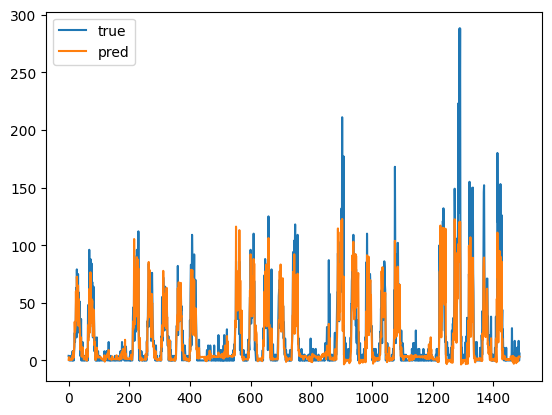

In [54]:
ts.fit_and_eval_forecast(data_counters_train, data_events_train, data_counters_test, data_events_test)

### Вывод по работе

Качество решения задачи можно оценить как неудовлетворительное. Метрики, полученные для классификации (F1-score и PR-score), указывают на низкую точность модели в определении наличия мероприятия в данный момент времени. F1-score равен 0.185, что значительно ниже желаемого значения 0.5 и выше, указывая на то, что модель не может надежно классифицировать данные. PR-score также низок, что подтверждает это заключение.

Что касается предсказания количества посетителей, метрики MAPE и MSE также указывают на низкую точность модели. MAPE равен 0.988, что означает, что модель имеет среднюю абсолютную процентную ошибку в 98.8%, что является неприемлемо высоким значением. MSE также высок, что подтверждает это заключение.

В целом, полученные метрики указывают на то, что модель требует значительной доработки и оптимизации для достижения удовлетворительного качества.

Однако, посмотрев на график, можно увидеть, что в целом предсказания довольно неплохи.